# W2 - Distance to entrances



### Pseudocode
```python
# initialization
import packages such as topogenesis, pyvista, numpy, ...
import envelope
import the locations of entrances

# Euclidean distance

substract centroids of voxels

for each centroid:
    distance_vector = []
    for each entrance:
        difference_vector = centroid - street_point
        distance = squareroot(difference[0]**2 + difference[1]**2)
    add to the distance matrix
make list of distances

distance to closest street point = distance.min()
Convert to lattice

# Manifold distance

select closest voxels from euclidian distance
create stencil

neighbours = closest_voxels.find_neighbours(stencil)

set furthest entrances to maximum distance and closest to zero in lattices

for each centroid:
    find neighbours of last step
    validate neighbours if inside envelope
    select next steps
    save the 'walked' distance
    extract minimum distance
    if all cells == filled:
        break

Construct lattice of minimum distances




    

    

## 0. Initialization

### 0.1 Importing the packages

In [8]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np

#pv.set_jupyter_backend("ipyvtklink")

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

### 0.2 import meshes

In [9]:
envelope_path = os.path.relpath('../Data/raw data/optional_envelope.obj')
context_path = os.path.relpath('../Data/raw data/immediate_context.obj')

# load the mesh from file
envelope_mesh = tm.load(envelope_path)
context_mesh = tm.load(context_path)

# Check if the mesh is watertight
print(envelope_mesh.is_watertight)
print(context_mesh.is_watertight)

True
False


In [10]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the meshes
p.add_mesh(tri_to_pv(envelope_mesh), color='#abd8ff')
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x00000230D0607CD0) at 0x00000230DC0A1220>

### 0.3 Importing the Envelope Lattice

In [11]:
# loading the lattice from csv
lattice_path = os.path.relpath('../Data/dynamic output/voxelized_envelope_highres.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)

### 0.4 Importing the Entrances

In [12]:
# import the streetnetwork as a point cloud
street_pc = tg.cloud_from_csv("../Data/raw data/entrances_envelope.csv")
street_pc[:,[1,2]] = street_pc[:,[2,1]]
street_pc[:,1] = street_pc[:,1] * -1

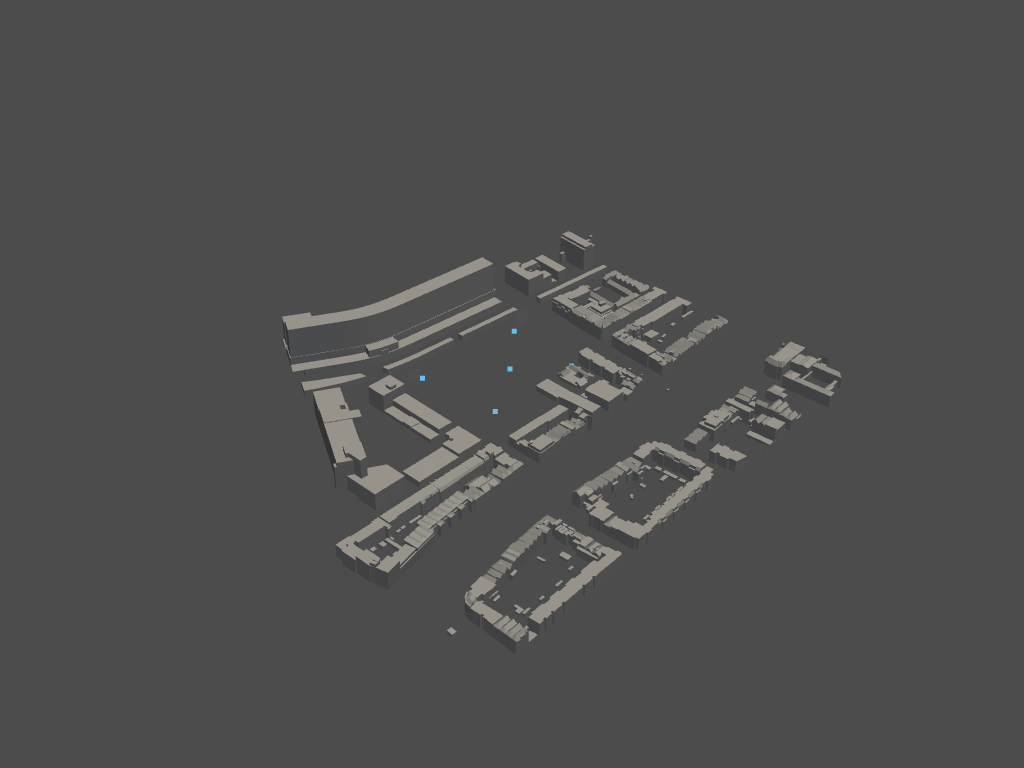

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [13]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
# envelope_lattice.fast_vis(p)

# fast visualization of the point cloud
street_pc.fast_notebook_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
p.show()

## 1. Euclidean Distance Lattice

### 1.1 Distance Matrix

In [14]:
# extracting the centroid of all voxels
env_cens = envelope_lattice.centroids_threshold(-1)

# initializing the distance matrix
dist_m = []
# for each voxel ...
for voxel_cen in env_cens:
    # initializing the distance vector (per each voxel)
    dist_v = []
    # for each street point ...
    for street_point in street_pc:
        # find the difference vector
        diff = voxel_cen - street_point
        # raise the components to the power of two
        diff_p2 = diff**2
        # sum the components
        diff_p2s = diff_p2.sum()
        # compute the square root 
        dist = diff_p2s**0.5
        # add the distance to the distance vector
        dist_v.append(dist)
    # add the distance vector to the distance matrix
    dist_m.append(dist_v)
# change the distance matrix type, from list to array
dist_m = np.array(dist_m)

### 1.2 Distance to Closest Street Point

In [15]:
# find the distance to the closest street point for each voxel
min_dist = dist_m.min(axis=1)
# convert the minimum distance list to a lattice
street_eu_distance_lattice = tg.to_lattice(min_dist.reshape(envelope_lattice.shape), envelope_lattice)
# zero the value of the exterior voxels
envelope_eu_dist_lattice = street_eu_distance_lattice * envelope_lattice

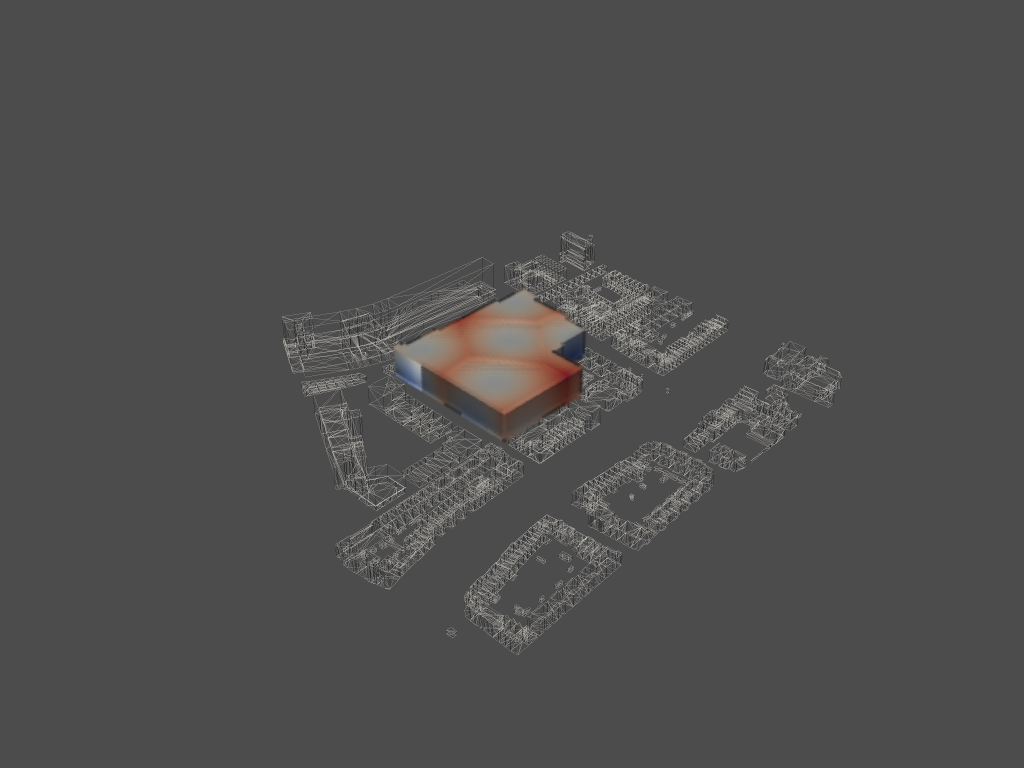

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [16]:
# initiating the plotter
p = pv.Plotter()

l = envelope_eu_dist_lattice * envelope_lattice

# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# fast visualization of the point cloud
street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show()

## 2 Manifold Distance Lattice

### 2.1 Selecting the Closest Voxels

In [17]:
# selecting the closest voxels by setting a threshold 
street_connection_lattice = (0 < envelope_eu_dist_lattice) * (envelope_eu_dist_lattice < 12)

### 2.2. The Stencil

In [18]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)

print(stencil)

[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 1 0]
  [1 0 1]
  [0 1 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]]


### 2.3 Initializing the Manifold Distance Lattice

In [19]:
# retrieve the neighbour list of each cell
neighs = street_connection_lattice.find_neighbours(stencil)

# set the maximum distance to sum of the size of the lattice in all dimensions.
max_dist = np.sum(street_connection_lattice.shape)

# initialize the street network distance lattice with all the street cells as 0, and all other cells as maximum distance possible
mn_dist_lattice = 1 - street_connection_lattice
mn_dist_lattice[mn_dist_lattice==1] = max_dist

# flatten the distance lattice for easy access
mn_dist_lattice_flat = mn_dist_lattice.flatten()

# flatten the envelope lattice
env_lat_flat = envelope_lattice.flatten()

### 2.4 Breadth-First Traversal

In [20]:
# main loop for breath-first traversal
for i in range(1, max_dist):
    # find the neighbours of the previous step
    next_step = neighs[mn_dist_lattice_flat == i - 1]
    # find the unique neighbours
    next_unq_step = np.unique(next_step.flatten())
    # check if the neighbours of the next step are inside the envelope
    validity_condition = env_lat_flat[next_unq_step]
    # select the valid neighbours
    next_valid_step = next_unq_step[validity_condition]
    # make a copy of the lattice to prevent overwriting in the memory
    mn_nex_dist_lattice_flat = np.copy(mn_dist_lattice_flat)
    # set the next step cells to the current distance
    mn_nex_dist_lattice_flat[next_valid_step] = i
    # find the minimum of the current distance and previous distances to avoid overwriting previous steps
    mn_dist_lattice_flat = np.minimum(mn_dist_lattice_flat, mn_nex_dist_lattice_flat)
    
    # check how many of the cells have not been traversed yet
    filled_check = mn_dist_lattice_flat * env_lat_flat == max_dist
    # if all the cells have been traversed, break the loop
    if filled_check.sum() == 0:
        print(i)
        break

# reshape and construct a lattice from the street network distance list
mn_dist_lattice = mn_dist_lattice_flat.reshape(mn_dist_lattice.shape)

27


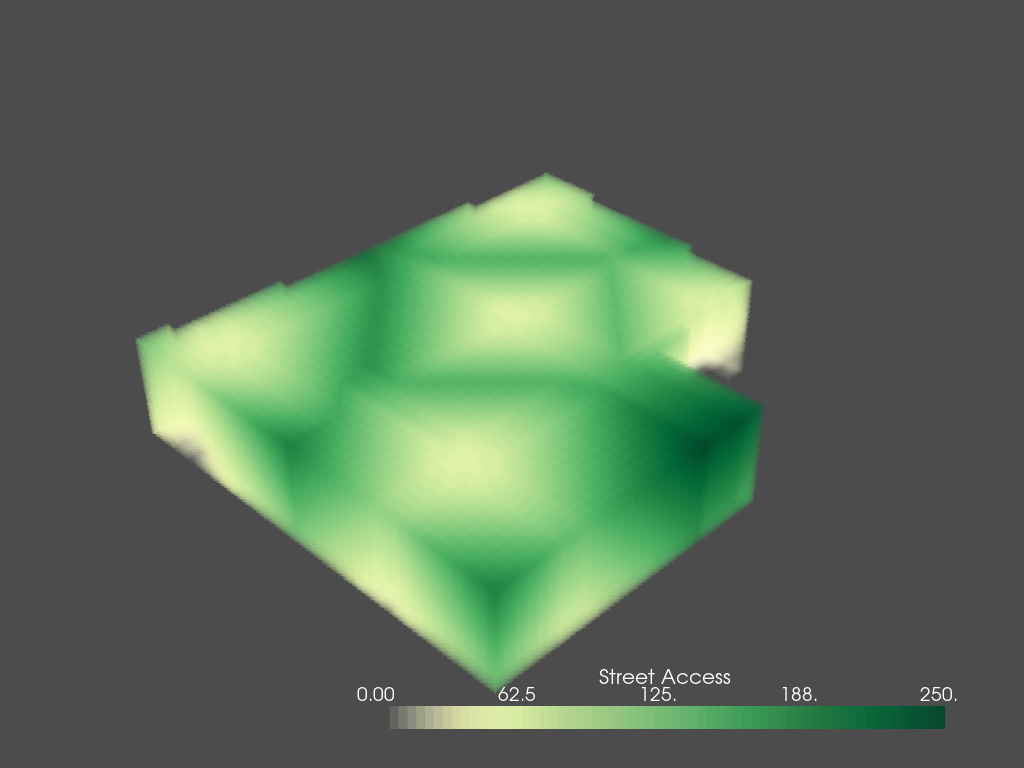

[(269.61191187360555, 188.61191187360552, 251.61191187360552),
 (36.000000000000014, -45.0, 18.0),
 (0.0, 0.0, 1.0)]

In [21]:
# set the lattice to be visualized
l = mn_dist_lattice * envelope_lattice
# remapping
l = 250 * (l - l.min()) / l.max()

# initiating the plotter
p = pv.Plotter(notebook=True)

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Street Access"] = l.flatten(order="F")  # Flatten the Lattice
    
# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="YlGn", opacity=opacity, shade=False, show_scalar_bar=True)

# plotting
p.show()

In [22]:
csv_path = os.path.relpath('../Data/dynamic output/dist_entrance.csv')
mn_dist_lattice.to_csv(csv_path)

## Credits

In [23]:
__author__ = "Shervin Azadi"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/earthy_workshops"
__summary__ = "Earthy Design Studio"